In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange

In [30]:
def dvdt(t, v, x1, x2):
    v1, v2 = tf.split(v, 2) 
    dv1dt = x1[tf.cast(tf.round(t), tf.int32)] -2*v1 + 8*v2 - x1[tf.cast(tf.round(t), tf.int32)]*v1
    dv2dt = x2[tf.cast(tf.round(t), tf.int32)] -5*v1 + v2 - x2[tf.cast(tf.round(t), tf.int32)]*v2
    dvdt = tf.concat([dv1dt, dv2dt], axis=0)
    return dvdt 

In [31]:
def generate_xs(nt):
    
    # initial values 
    x1 = np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
    x2 = np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))

    for i in range(nt): 
        # generate a bernouilli according to PD
        p1 = np.random.binomial(1,p=0.65)
        p2 = np.random.binomial(1,p=0.99)
        u1 = np.absolute(np.array([np.random.uniform(low=-0.5, high=0.5)]))
        u2 = np.absolute(np.array([np.random.uniform(low=-1.0, high=1.0)]))
        x1 = np.append(x1, x1[-1]+p1*u1, axis=0)
        x2 = np.append(x2, x2[-1]+p2*u2, axis=0)
    return x1, x2

In [32]:
ODESolver = tfp.math.ode.DormandPrince()

# initial conditions and time grid
t_initial = 0 # initial time
t_final = 8 # final time
n_times = 80 # number of time steps to churn out solution for
times = np.linspace(t_initial, t_final, n_times).astype(np.float32)

# generate trajectories
n_trajectories = 100
trajectories = []
xs = []
for i in range(n_trajectories):
    # initial conditions
    v_initial = np.random.uniform(low=-1.0, high=1.0, size=2).astype(np.float32)

    # xs
    x1, x2 = generate_xs(n_times)
    
    # integrate the ODE
    results = ODESolver.solve(dvdt, # system of ODEs (gradient function)
                                       t_initial, # initial time
                                       v_initial, # initial state
                                       solution_times=times,
                                       constants={'x1': x1.astype(np.float32),'x2': x2.astype(np.float32)}) # time grid to spit out solutions for

    # extract results for the state solutions v(t)
    data = tf.stack(results.states, axis=0)
    
    # append
    trajectories.append(data)
    xs.append(tf.stack([x1, x2], axis=-1))
    
trajectories = tf.stack(trajectories, axis=0)
xs = tf.stack(xs, axis=0)

In [33]:
class RecurrentNetworkODE(tf.keras.Model):
    """
    RNN ODE model (a la Bailer Jones et al)
    """

    def __init__(self, n_dimensions, n_inputs, n_hidden=128, activation=tf.tanh, optimizer=tf.keras.optimizers.Adam()):
        
        # super
        super(RecurrentNetworkODE, self).__init__()
        
        self.n_dimensions = n_dimensions
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.activation = activation
        self.optimizer = optimizer
        
        # weights and biases
        self.W1x = tf.Variable(tf.random.normal([n_inputs, n_hidden], 0, 1e-3))
        self.W1v = tf.Variable(tf.random.normal([n_dimensions, n_hidden], 0, 1e-3))
        self.b1 = tf.Variable(tf.random.normal([n_hidden], 0, 1e-3))
        self.W2 = tf.Variable(tf.random.normal([n_hidden, n_dimensions], 0, 1e-3))
        self.b2 = tf.Variable(tf.random.normal([n_dimensions], 0, 1e-3))
    
    # call jsut calculates the derivative
    @tf.function
    def call(self, v, x, t):
        
        return tf.matmul(self.activation(tf.matmul(v, self.W1v) + tf.matmul(x, self.W1x) + self.b1), self.W2) + self.b2

    @tf.function
    def trajectories(self, v0, x, t):
        
        # number of time steps
        nt = t.shape[-1]
        
        # initialize state (init zeros for all but initial conditions)
        v = [v0] + [tf.zeros([self.n_dimensions]) for _ in range(nt-1)]
        
        # euler steps
        for k in range(1, nt):
            v[k] = v[k-1] + self.call(v[k-1], x[:,tf.cast(tf.round(t[k]), tf.int32),:], t[k])*(t[k]-t[k-1])
            
        # stack the outputs into full trajectories
        return tf.stack(v, axis=1)

In [34]:
model = RecurrentNetworkODE(2, 2, n_hidden=128, activation=tf.tanh)

In [100]:
epochs = 10000
v0 = tf.constant(trajectories[:,0,:])
times = tf.constant(times)
x = tf.cast(xs[:,1:,:], tf.float32)
nt=times.shape[-1]
v = [v0] + [tf.zeros([2]) for _ in range(nt-1)]

predicted_trajectories = model.trajectories(v0, x, times)


for k in range(1, nt):
    v[k] = v[k-1] + model.call(v[k-1], x[:,tf.cast(tf.round(times[k]), tf.int32),:], times[k])*(times[k]-times[k-1])
#pred=model.call(v[1], x[:,tf.cast(tf.round(times[2]), tf.int32),:], times[2])*(times[1]-times[0]) 
#len(pred)

In [83]:
predicted_trajectories = model.trajectories(v0, x, times)

In [35]:
epochs = 10000
v0 = tf.constant(trajectories[:,0,:])
times = tf.constant(times)
x = tf.cast(xs[:,1:,:], tf.float32)

with trange(epochs) as t:
    for epoch in t:
        
        with tf.GradientTape() as tape:
            tape.watch(model.trainable_variables)
            predicted_trajectories = model.trajectories(v0, x, times)
            loss = tf.reduce_mean(tf.math.squared_difference(trajectories, predicted_trajectories))
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        t.set_postfix(loss=loss.numpy())

100%|██████████| 10000/10000 [08:01<00:00, 20.76it/s, loss=0.00189]


In [36]:
predicted_trajectories = model.trajectories(v0, x, times)

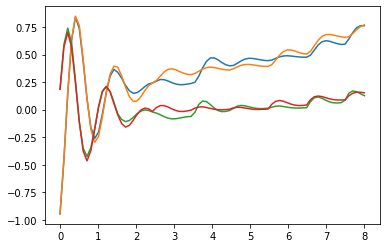

In [37]:
i = 13
plt.plot(times, trajectories[i,:,0])
plt.plot(times, predicted_trajectories[i,:,0])

plt.plot(times, trajectories[i,:,1])
plt.plot(times, predicted_trajectories[i,:,1])

plt.show()

In [38]:
x.shape

TensorShape([100, 80, 2])

In [39]:
predicted_trajectories.shape

TensorShape([100, 80, 2])

# Chen 

In [111]:
#from torchdiffeq import odeint_adjoint as odeint
import torch
import torch.nn as nn


80

In [110]:
class ODE_fun(tf.keras.Model):
    """
    Feedforward network 
    """

    def __init__(self, n_dimensions, n_inputs, n_hidden=128, activation=tf.tanh, optimizer=tf.keras.optimizers.Adam()):
        
        # super
        super(ODE_fun, self).__init__()
        
        self.n_dimensions = n_dimensions
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.activation = activation
        self.optimizer = optimizer
        
        # weights and biases
        self.W1x = tf.Variable(tf.random.normal([n_inputs, n_hidden], 0, 1e-3))
        self.W1v = tf.Variable(tf.random.normal([n_dimensions, n_hidden], 0, 1e-3))
        self.b1 = tf.Variable(tf.random.normal([n_hidden], 0, 1e-3))
        self.W2 = tf.Variable(tf.random.normal([n_hidden, n_dimensions], 0, 1e-3))
        self.b2 = tf.Variable(tf.random.normal([n_dimensions], 0, 1e-3))
    
    # call jsut calculates the derivative
    @tf.function
    def call(self, v, x, t):
        
        return tf.matmul(self.activation(tf.matmul(v, self.W1v) + tf.matmul(x[tf.cast(tf.round(t), tf.int32)], self.W1x) + self.b1), self.W2) + self.b2




In [113]:
func=ODE_fun(2, 2, n_hidden=128, activation=tf.tanh)

epochs = 10000
v0 = tf.constant(trajectories[:,0,:])
times = tf.constant(times)
x = tf.cast(xs[:,1:,:], tf.float32)
nt=times.shape[-1]

for i in range(n_trajectories):
    v_init=v0[i]
    var=x[i]
    preds_ODE = ODESolver.solve(func.call, # system of ODEs (gradient function)
                                       t_initial, # initial time
                                       v_init, # initial state
                                       solution_times=times,
                                       constants={'x': var}) # time grid to spit out solutions for



TypeError: call(v, x, t) got two values for argument 'x'